In [47]:
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

In [57]:
#load in SATURN results and create final df based on PCs for each cell, cell type label, and species label
#note: adjust number of PCs to encompass 90% of variation for best model performance
#note: in this example, CT labels are stored in "labels2"
adata = sc.read("/home/apennacchio/pcsct/saturn/out/14/test256_data_sbicolor_root10_integrated_zmays23_org_saturn_seed_0.h5ad")
sc.pp.pca(adata, n_comps=14)
print(np.sum(adata.uns['pca']['variance_ratio']))

pc_df = pd.DataFrame(adata.obsm['X_pca'])
pc_df = pc_df.set_index(adata.obs.index)
final_df = pd.concat([pc_df, adata.obs['labels2'], adata.obs['species']], axis = 1)

0.9181672


In [49]:
#encode CT labels as numbers, required by model
y = final_df["labels2"]
labelencoder = LabelEncoder()
final_Y = labelencoder.fit_transform(y)
#store encoded labels in "category" column
final_df["category"] = final_Y

In [50]:
#break into sorghum/maize dataframes
df_s = final_df[final_df['species'] == 'sorghum']
df_z = final_df[final_df['species'] == 'zmays']
df_s = df_s.drop(labels=["species"], axis=1)
df_z = df_z.drop(labels=["species"], axis=1)

In [51]:
#establish training and test datasets (sorghum is train, maize is test)
X_train = df_s.drop(labels=["labels2", "category"], axis=1)
Y_train = df_s["category"]
X_test = df_z.drop(labels=["labels2", "category"], axis=1)
Y_test = df_z["category"]


In [52]:
#XGBoost classifier model. Parameters with largest effects on performance are max_depth and min_child_weight, in my experience. n_estimators is number of trees

bst = XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 seed=27)


In [53]:
# fit model
bst.fit(X_train, Y_train)
# make predictions
preds = bst.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (Y_test != preds).sum()))

Number of mislabeled points out of a total 1927 points : 123


Text(0.5, 1.0, 'Label Transfer Accuracy by Cell Type')

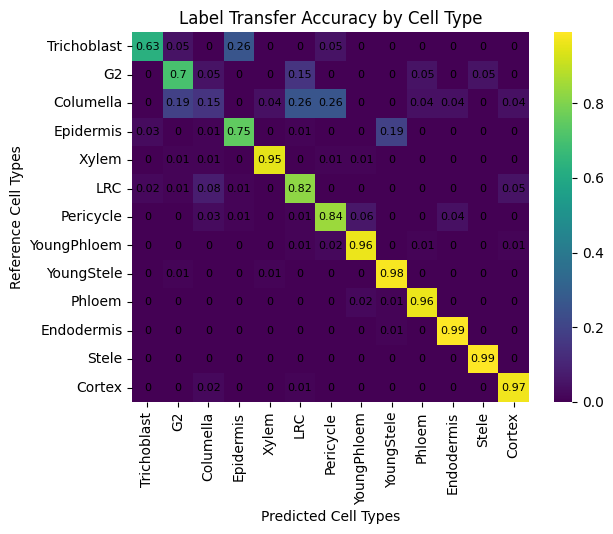

In [54]:

#transform classifier's numerical to CT labels
y_pred = labelencoder.inverse_transform(preds)
y_true = labelencoder.inverse_transform(Y_test)

#establish confusion matrix 
cm = confusion_matrix(y_true, y_pred)
row_sums = cm.sum(axis=1, keepdims=True)
cm = cm / row_sums
cm = np.round(cm, 2)

cell_types = ['Columella', 'Cortex', 'Endodermis', 'Epidermis', 'G2', 'LRC', 'Pericycle', 
              'Phloem', 'Stele', 'Trichoblast', 'Xylem', 'YoungPhloem', 'YoungStele']
desired_order = [
    "Trichoblast", "G2", "Columella", "Epidermis", "Xylem", "LRC",
    "Pericycle", "YoungPhloem", "YoungStele", "Phloem", "Endodermis", "Stele", "Cortex"
]

#convert to df to reorder by number of cells for each cell type
confusion_df = pd.DataFrame(cm)
confusion_df.columns = cell_types
confusion_df.index = cell_types
confusion_df = confusion_df.reindex(index=desired_order, columns=desired_order)
confusion_matrix_np = confusion_df.to_numpy()
cm = confusion_matrix_np


#plot heatmap
sns.heatmap(cm, annot=cm, annot_kws={"size": 8, 'color': 'black'}, cmap='viridis', xticklabels=desired_order, yticklabels=desired_order) 
plt.xlabel('Predicted Cell Types')
plt.ylabel('Reference Cell Types')
plt.title('Label Transfer Accuracy by Cell Type')



/opt/conda/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


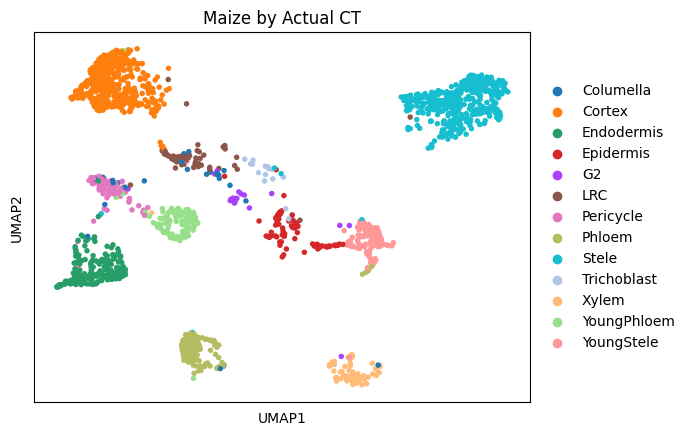

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


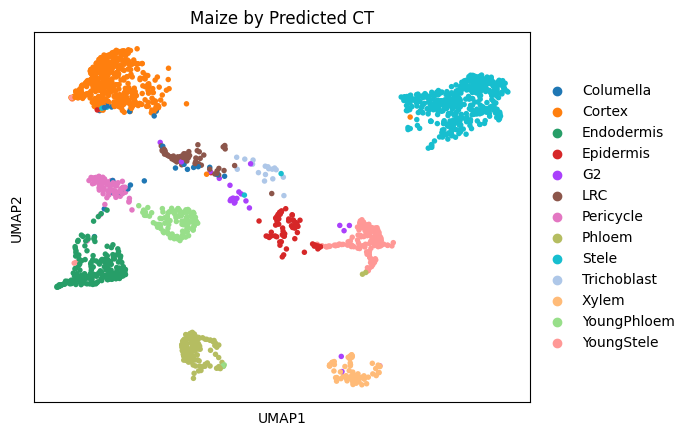

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


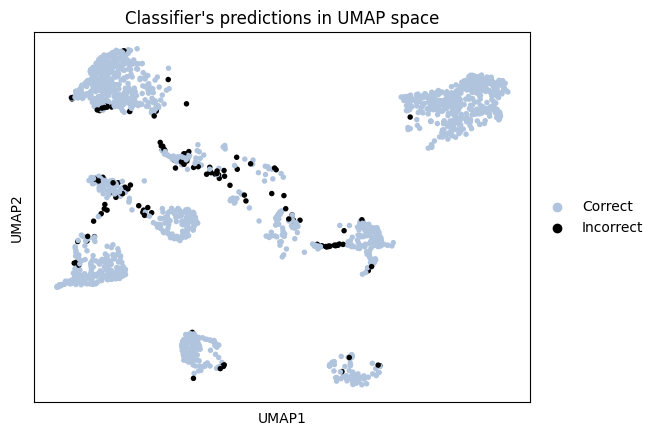

In [55]:
#convert classifier's numerical predicitions to CT
preds = labelencoder.inverse_transform(preds)

#UMAP computation
sc.pp.neighbors(adata)
sc.tl.umap(adata)

#visualize maize's predicted vs actual labels in UMAP space
zdata = adata[adata.obs['species'] == 'zmays']
sc.pl.umap(zdata, color="labels2", title="Maize by Actual CT")
zdata.obs["predicted"] = preds
sc.pl.umap(zdata, color="predicted", title="Maize by Predicted CT")
zdata.obs['Correct'] = np.where(zdata.obs['predicted'] == zdata.obs['labels2'], "Correct", "Incorrect")
sc.pl.umap(zdata, color="Correct", title="Classifier's predictions in UMAP space", palette={"Correct": "lightsteelblue", "Incorrect": "black"})

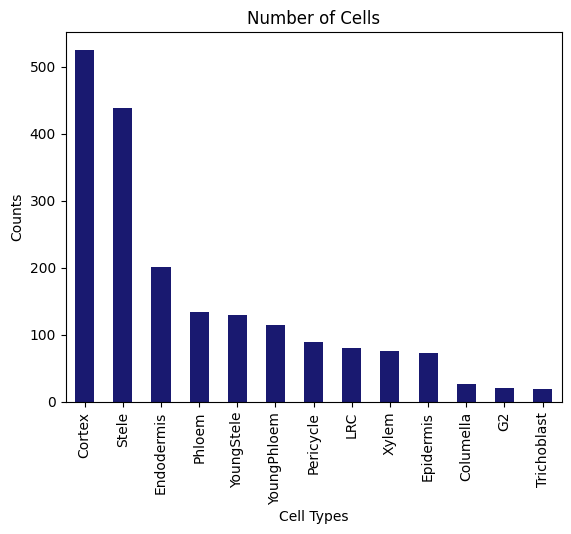

In [56]:

#visualize number of cells by CT
label_counts = zdata.obs['labels2'].value_counts()

label_counts.plot(x='labels2', kind='bar', stacked=True,
        title='Number of Cells',
        xlabel='Cell Types',
        ylabel='Counts',
        legend=False,
        color='midnightblue'
           )
plt.show()